In [1]:
"""
this block is needed at the beginning of all notebooks to be able to load modules
"""
import os
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Automatically find and append the project root
root_path = Path.cwd().resolve().parents[1]  # adjust level as needed
data_path = os.path.join(root_path, "data")
src_path = os.path.join(root_path, "src")

if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

In [2]:
from signal_modules.signal_registry import SignalRegistry
from backtesting.backtester import BacktestEngine
from investor.portfolio_registry import PortfolioRegistry

In [3]:
portfolio_registry = PortfolioRegistry()
portfolio_registry.available()

['default']

In [4]:
default_portfolio = portfolio_registry.get('default')

In [5]:
tickers = ['SPY', 'AAPL', 'MSFT', 'BRK-B', 'SBUX', 'META', 'GOOG']  # List of tickers
data = {ticker: pd.read_parquet(os.path.join(data_path, f"{ticker}.parquet")) for ticker in tickers}
data

{'SPY':                               close      high       low      open    volume  \
 date                                                                          
 1993-01-29 00:00:00+00:00   43.9375   43.9687   43.7500   43.9687   1003200   
 1993-02-01 00:00:00+00:00   44.2500   44.2500   43.9687   43.9687    480500   
 1993-02-02 00:00:00+00:00   44.3437   44.3750   44.1250   44.2187    201300   
 1993-02-03 00:00:00+00:00   44.8125   44.8437   44.3750   44.4062    529400   
 1993-02-04 00:00:00+00:00   45.0000   45.0937   44.4687   44.9687    531500   
 ...                             ...       ...       ...       ...       ...   
 2025-05-07 00:00:00+00:00  561.1500  563.8200  556.0400  560.1500  55733229   
 2025-05-08 00:00:00+00:00  565.0600  570.3100  561.7000  565.2400  65130787   
 2025-05-09 00:00:00+00:00  564.3400  567.5000  562.7637  566.4800  36664070   
 2025-05-12 00:00:00+00:00  582.9900  583.0000  577.0400  581.4700  78993570   
 2025-05-13 00:00:00+00:00  586.8

In [6]:
signal_registry = SignalRegistry()

In [7]:
signal_registry.available_signals()

['ma_crossover', 'Kalman']

In [8]:
model2 = signal_registry.get('ma_crossover')()
model3 = signal_registry.get('Kalman')()

In [9]:
bt = BacktestEngine(
    data = data, 
    modules_weights = [(model3, 1)], 
    portfolio=default_portfolio
)

In [10]:
bt.run()

Backtesting: 100%|██████████| 1348/1348 [00:00<00:00, 3600.79it/s]


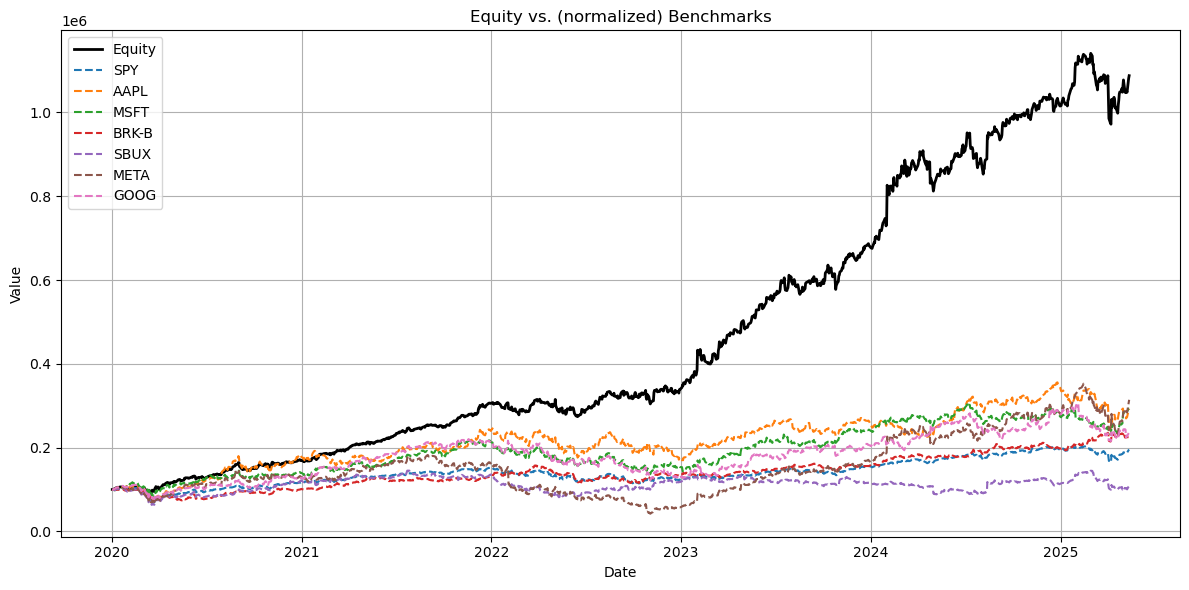

In [11]:
bt.equity_vs_benchmarks(benchmarks=tickers)

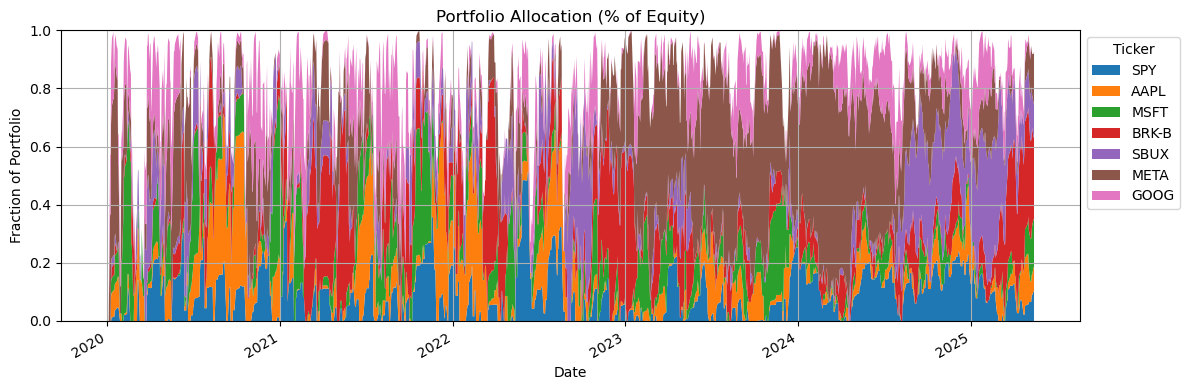

In [12]:
bt.holdings_over_time()